In [1]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
if 'changed' not in globals():
    os.chdir("..")
    os.chdir("..")
    global changed
    changed = True
import numpy as np
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee
import SR_hetro as srh

In [2]:
config_path = "configs/Gaillard/configs_common_tern"
config = cl.read_configs(config_path)
path =config.get('DEFAULT','results_csv_file_name')
temp_results_path = os.path.join('temp_results',path)
results_path = os.path.join('results_csvs/Gaillard',path)
apply_thresh = True
scale =365


In [3]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [4]:
config = cl.read_configs(config_path)
nsteps = int(config.get('DEFAULT', 'nsteps'))
npeople = int(config.get('DEFAULT', 'npeople'))
t_end = int(config.get('DEFAULT', 't_end'))
nwalkers = int(config.get('DEFAULT', 'nwalkers'))
nsteps = int(config.get('DEFAULT', 'nsteps'))
num_mcmc_steps = int(config.get('DEFAULT', 'n_mcmc_steps'))
metric = config.get('DEFAULT', 'metric')
time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
data_file = config.get('DEFAULT', 'data_file')
seed_file = config.get('DEFAULT', 'seed_file')
variations = ast.literal_eval(config.get('DEFAULT', 'variations'))
prior = ast.literal_eval(config.get('DEFAULT', 'prior'))
transform = bool(config.get('DEFAULT', 'transform'))
index = int(config.get('DEFAULT', 'index'))
submission_folder = config.get(f'SUBMISSION_{index-1}', 'submission_folder')
external_hazard = ast.literal_eval(config.get('DEFAULT', 'external_hazard'))
hetro = config.getboolean('DEFAULT', 'hetro',fallback=False)

#all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
# (remove everything before the current folder name)
data_file = data_file.split(current_folder)[-1]
seed_file = seed_file.split(current_folder)[-1]
submission_folder = submission_folder.split(current_folder)[-1]
#remove the first / from the paths
data_file = data_file[1:]
seed_file = seed_file[1:]
submission_folder = submission_folder[1:]



h5_folder = f"{submission_folder}/h5_files"

In [5]:
ds = dtds.dsFromFile(data_file)
ds.external_hazard = external_hazard
seed_res = rr.readResultsFile(seed_file)
res_df = seed_res[1]
seed = rr.getTheta(res_df)
if transform:
    seed_trans = srmc.transform(seed)

Reading Common_tern_seed


In [6]:
samples_trans0, lnprobs0 = srmc.loadSamplesFromDir(h5_folder, best=False, thin =5, discard=200)


In [7]:
print(np.max(lnprobs0))

-2837.8130426140774


In [8]:
print(len(lnprobs0))
print(len(samples_trans0))

2464430
2464430


thresh: -2882.5912236541108


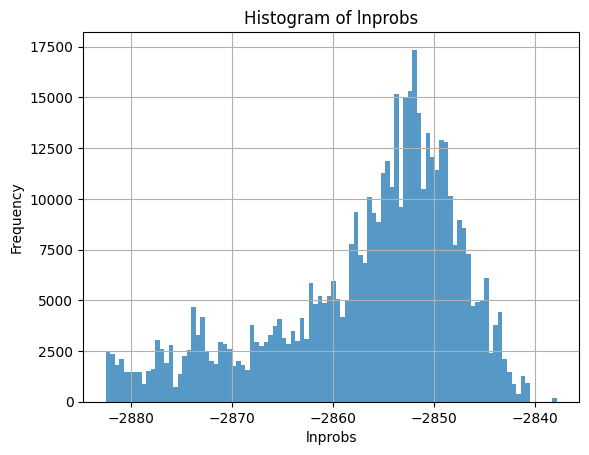

In [11]:
#plot a histogram of lnprobs2
#thresh is the threshold for lnprobs. lnprobs below thresh are not plotted
#thresh is the 95th percentile of lnprobs
thresh = np.percentile(lnprobs0, 80)
print(f"thresh: {thresh}")
# thresh =-np.inf

plt.hist(lnprobs0[lnprobs0>thresh], bins=100, alpha=0.75)
plt.xlabel('lnprobs')
plt.ylabel('Frequency')
plt.title('Histogram of lnprobs')
plt.grid(True)
plt.show()

In [12]:
if apply_thresh:
    samples_trans = samples_trans0[lnprobs0>thresh]
    lnprobs = lnprobs0[lnprobs0>thresh]

In [13]:
sorted_samples_trans = samples_trans[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
p1,p2,p3,p4 = srmc.get_params_from_thetas(sorted_samples_trans)
medians_trans = [np.median(p1),np.median(p2),np.median(p3),np.median(p4)]
means_trans = [np.mean(p1),np.mean(p2),np.mean(p3),np.mean(p4)]
stds_trans = [np.std(p1),np.std(p2),np.std(p3),np.std(p4)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev_trans = [median_abs_deviation(p1),median_abs_deviation(p2),median_abs_deviation(p3),median_abs_deviation(p4)]
best_theta_trans = sorted_samples_trans[-1]

In [14]:
samples =np.array([srmc.inv_transform(sample) for sample in samples_trans])

In [15]:
sorted_samples = samples[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
etas,betas,epsilons,xcs = srmc.get_params_from_thetas(sorted_samples)
medians = [np.median(etas),np.median(betas),np.median(epsilons),np.median(xcs)]
means = [np.mean(etas),np.mean(betas),np.mean(epsilons),np.mean(xcs)]
stds = [np.std(etas),np.std(betas),np.std(epsilons),np.std(xcs)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev = [median_abs_deviation(etas),median_abs_deviation(betas),median_abs_deviation(epsilons),median_abs_deviation(xcs)]

best_theta = sorted_samples[-1]

(25,)


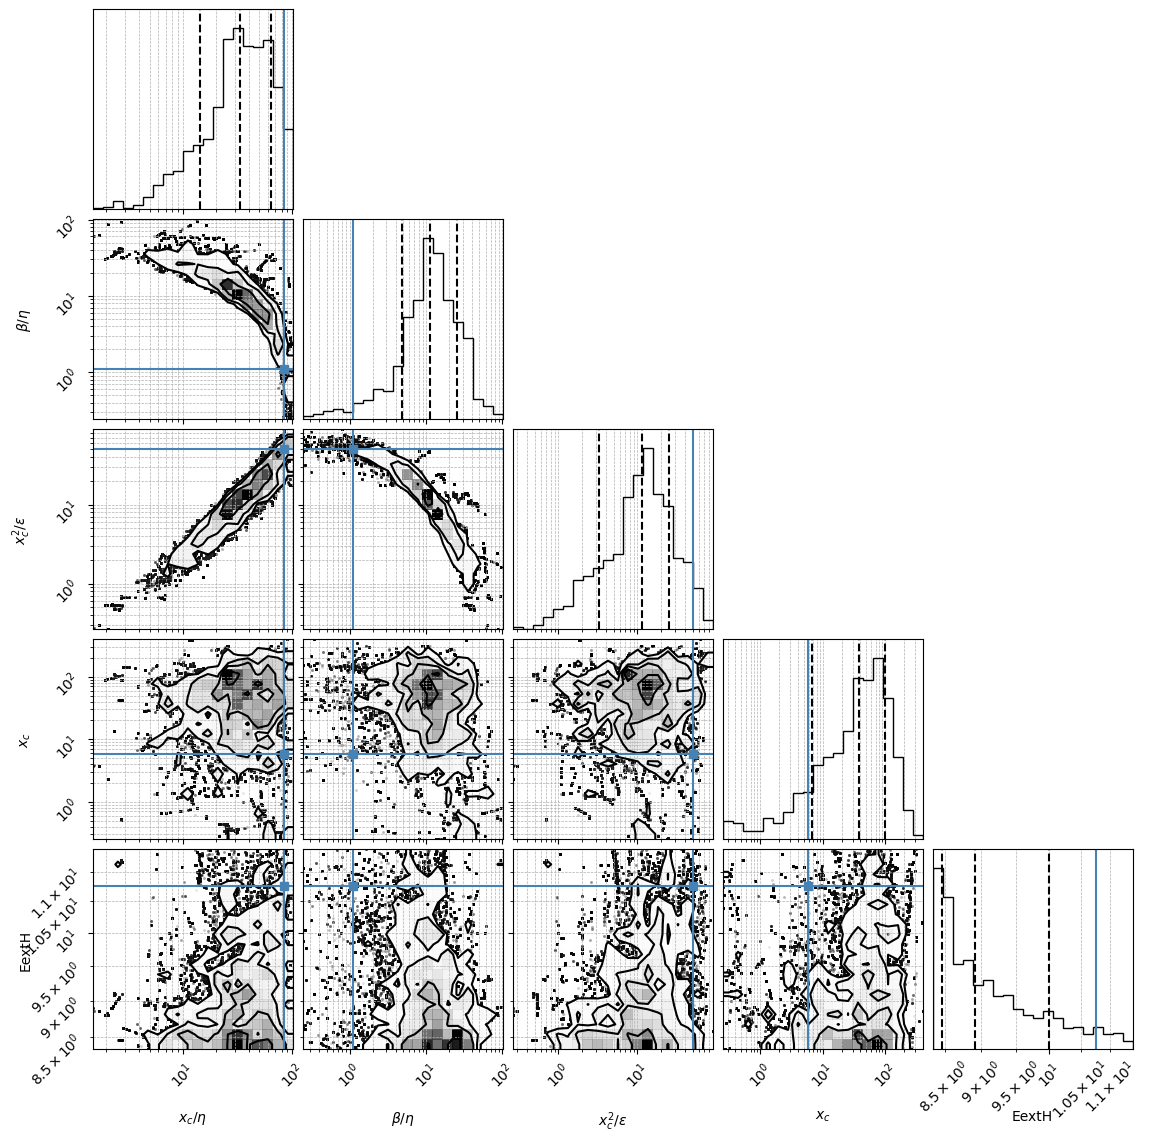

In [16]:
fig = corner.corner(samples_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","EextH"], axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=best_theta_trans)
axes=fig.get_axes()
print(np.shape(axes))
for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

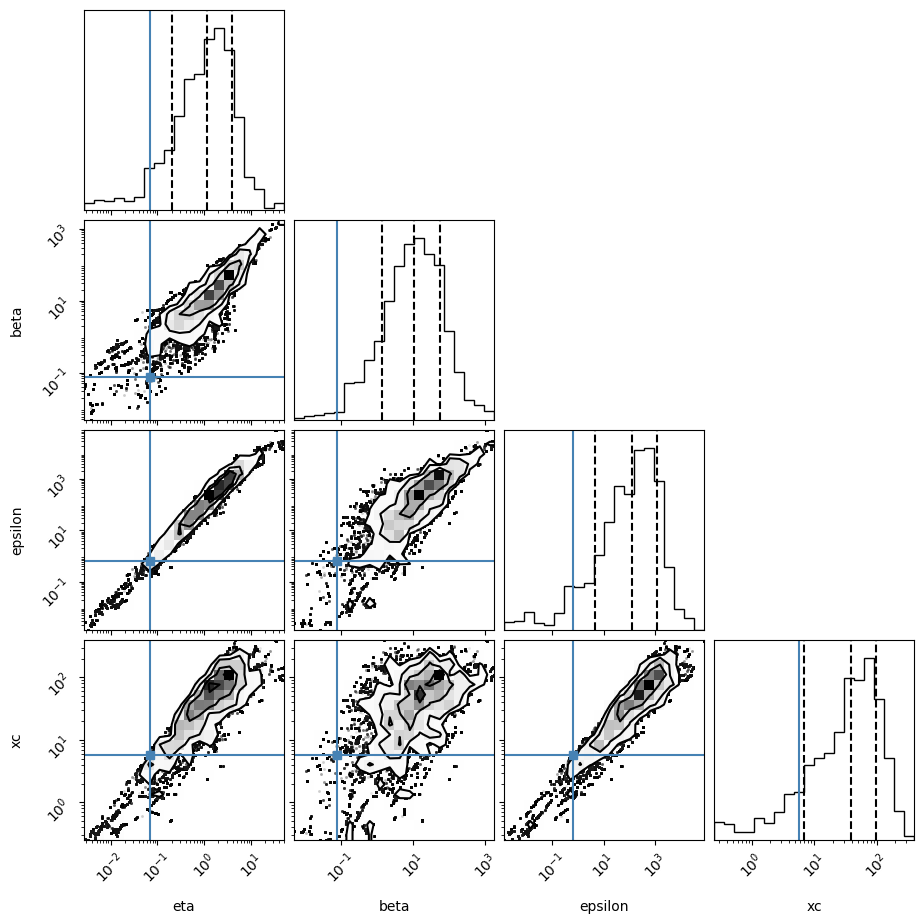

In [17]:
fig = corner.corner(samples, labels=['eta','beta','epsilon','xc','ExtH'],axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=best_theta)

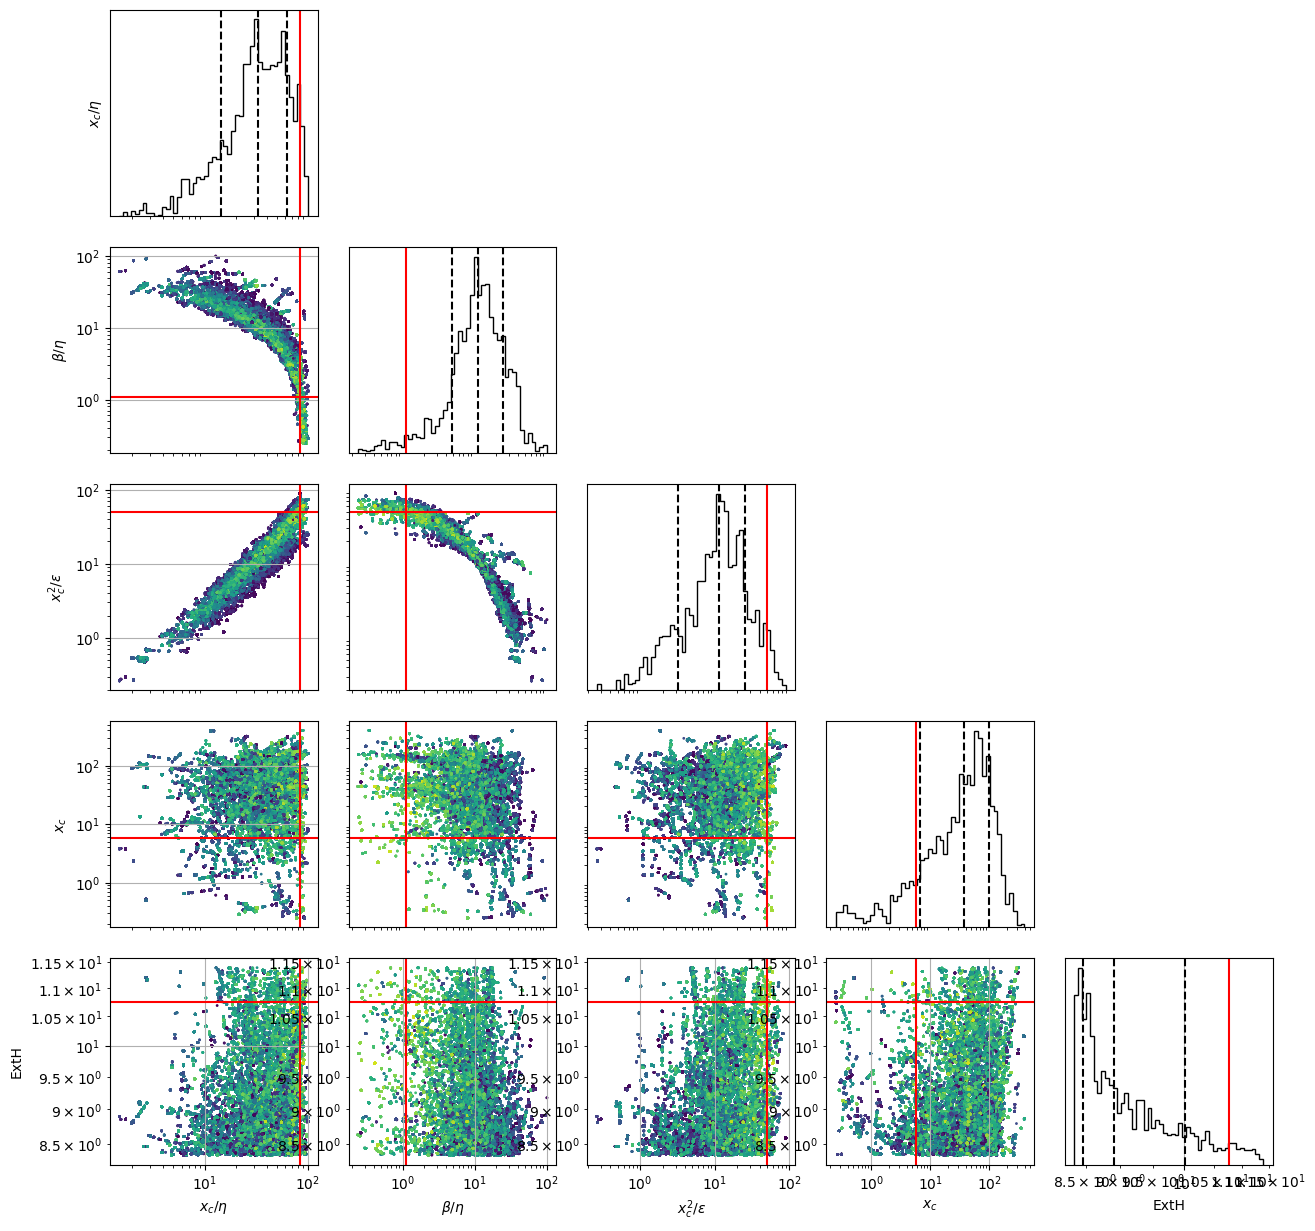

In [18]:
fig,ax=srmc.custom_corner(samples_trans,lnprobs, truths= best_theta_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"])

In [19]:

fact=1
import boltsman_stats as bs
dfb = bs.get_stats(samples, lnprobs,ds, file_path=temp_results_path,percent=False)

                             Eta     Beta  Epsilon     Xc  Beta/Eta  Beta*Xc/Eps  Fx=Beta^2/(Eta*Xc)  Dx=Beta*Eps/(Eta*Xc^2)  Xc^2/Eps  Beta*Kappa/Eps  Fk=Beta^2/(Eta*Kappa)  Dk=Beta*Eps/(Eta*Kappa^2)  s=(Xc^1.5*Eta^0.5)/Eps  Slope=Eta*Xc/Eps  Xc/Eps  Fk/Dk    Fk^2/Dk  t_eta  Median Lifetime
Best fit                   0.069    0.075     0.66   5.76      1.10         0.66               0.014                   0.022     50.29           0.057                   0.17                       2.90                    5.49             0.600    8.74  0.057     0.0095   9.16            10.00
Median                     1.160   10.390   127.53  38.22     11.24         3.82               3.910                   1.040     11.34           0.045                 227.92                    4612.28                    1.91             0.330    0.31  0.045    15.0100   5.76            10.00
Mean                       2.250   46.050   870.02  53.03     14.78         4.04              42.490                   5.

In [20]:
print(best_theta_trans)

[83.86483351  1.10004686 50.28745377  5.7551506  10.76276592]


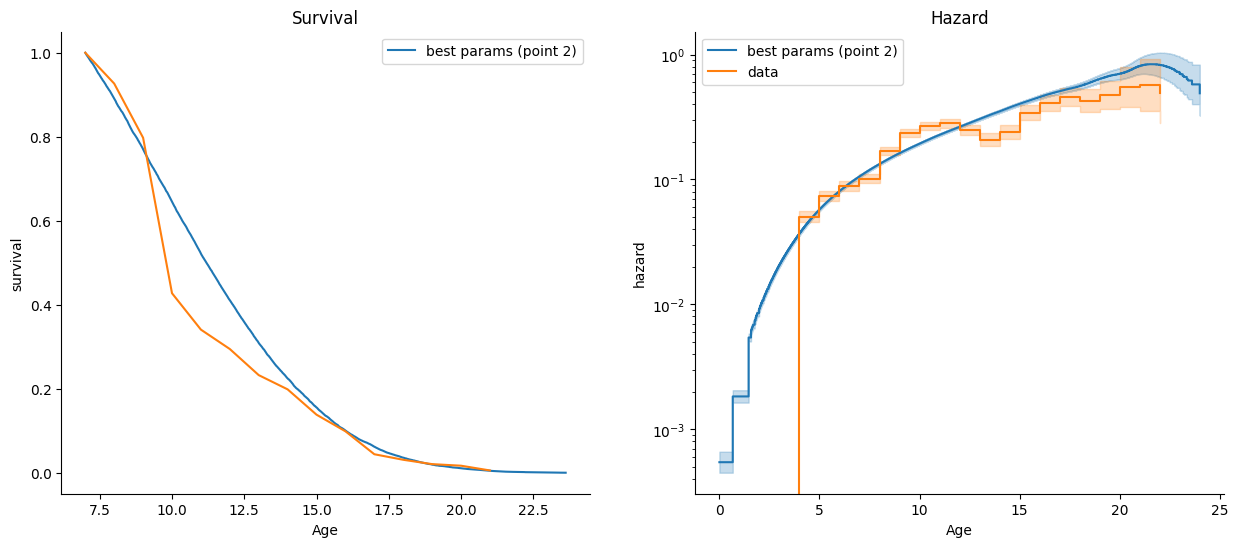

In [21]:
best_theta = sorted_samples[-1]
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

best_sim = srh.getSrHetro(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=best_theta_trans[4], parallel=True,hetro=hetro)

# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0],time_range=time_range, label='best params (point 2)', title='Survival', xlabel='time [years]', ylabel='survival')
ds.plotSurvival(ax=ax0, time_range=time_range,label='data')

# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time [years]', ylabel='hazard', label='best params (point 2)')
ds.plotHazard(ax=ax1, label='data')
ax1.set_yscale('log')

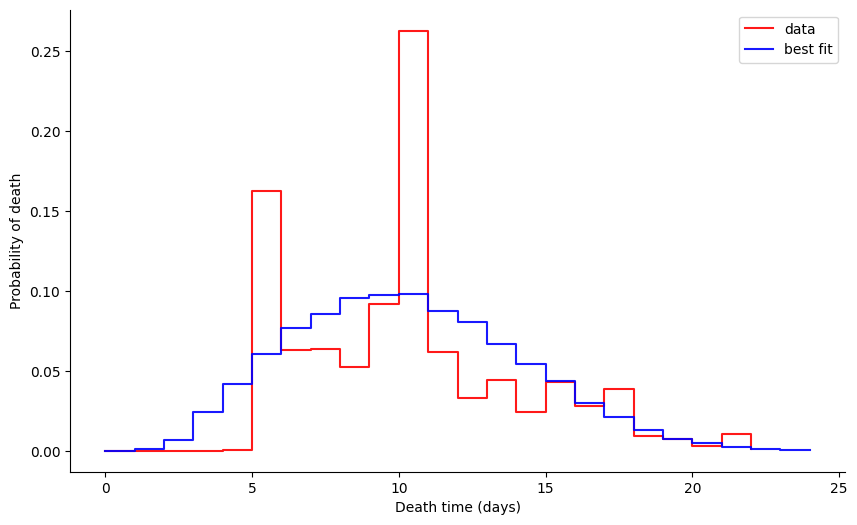

In [30]:
#add plots of the death time distributions of the best fit and data:
fig,ax = plt.subplots(1,1, figsize=(10,6))
ds.plotDeathTimesDistribution(ax=ax,use_kde=False ,label='data', color='r',alpha=0.9)
best_sim.plotDeathTimesDistribution(ax=ax,use_kde=False, label='best fit', color='b',alpha=0.9)
ax.legend()


Averaging log-probabilities: 100%|██████████| 6471/6471 [00:00<00:00, 251050.69it/s]


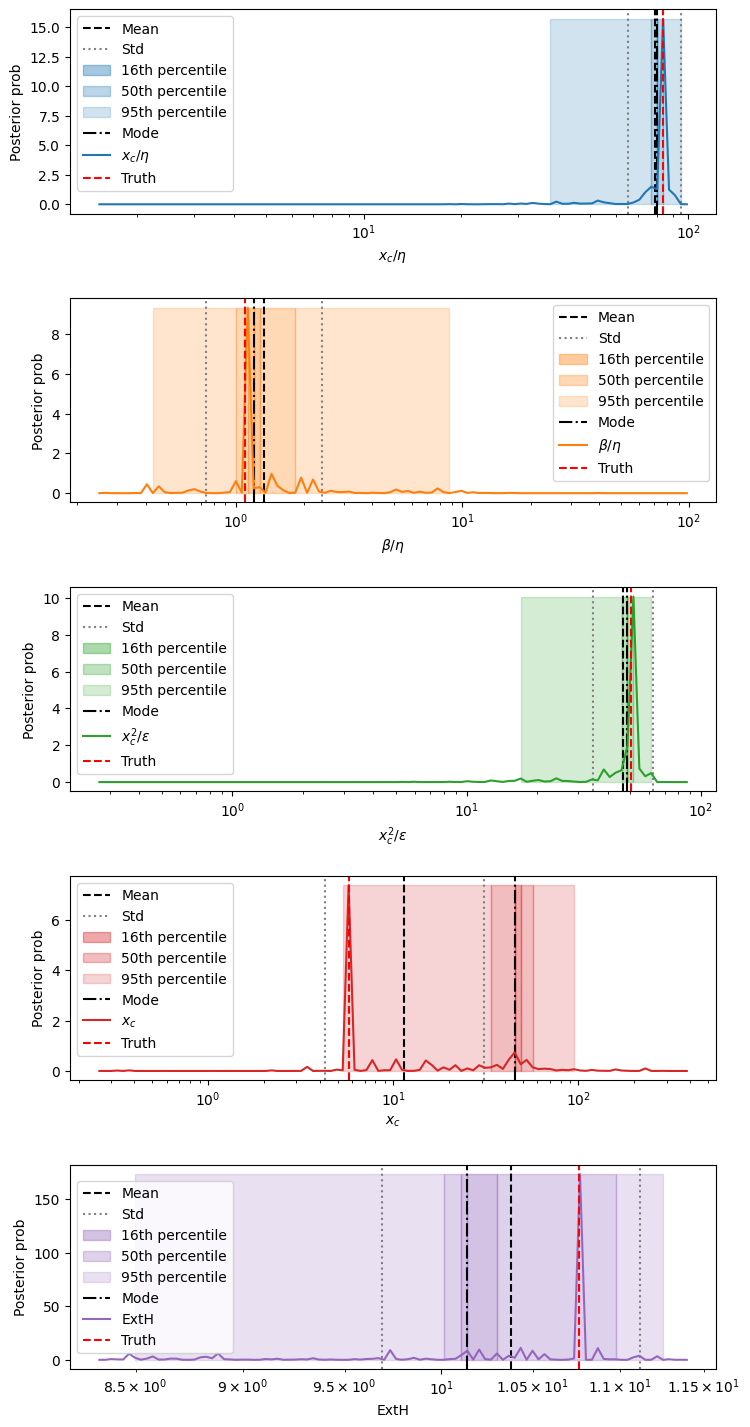

In [23]:
import samples_utils as su

post = su.Posterior(samples_trans, lnprobs, 100, log=True)
post.plot_1d_posteriors(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"], truths=sorted_samples_trans[-1],scale='log')

Creating corner plot:   0%|          | 0/5 [00:00<?, ?it/s]/Volumes/alon/navehr/baysian01/samples_utils.py:628: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X, Y, Z, **kwargs)
Creating corner plot: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


array([[<Axes: xlabel='$x_c/\\eta$', ylabel='Posterior prob'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$\\beta/\\eta$'>,
        <Axes: xlabel='$\\beta/\\eta$', ylabel='Posterior prob'>,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$x_c^2/\\epsilon$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\beta/\\eta$', ylabel='$x_c^2/\\epsilon$'>,
        <Axes: xlabel='$x_c^2/\\epsilon$', ylabel='Posterior prob'>,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$x_c$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\beta/\\eta$', ylabel='$x_c$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$x_c^2/\\epsilon$', ylabel='$x_c$'>,
        <Axes: xlabel='$x_c$', ylabel='Posterior prob'>, <Axes: >],
       [<Axes: title={'center': '2D Posterio

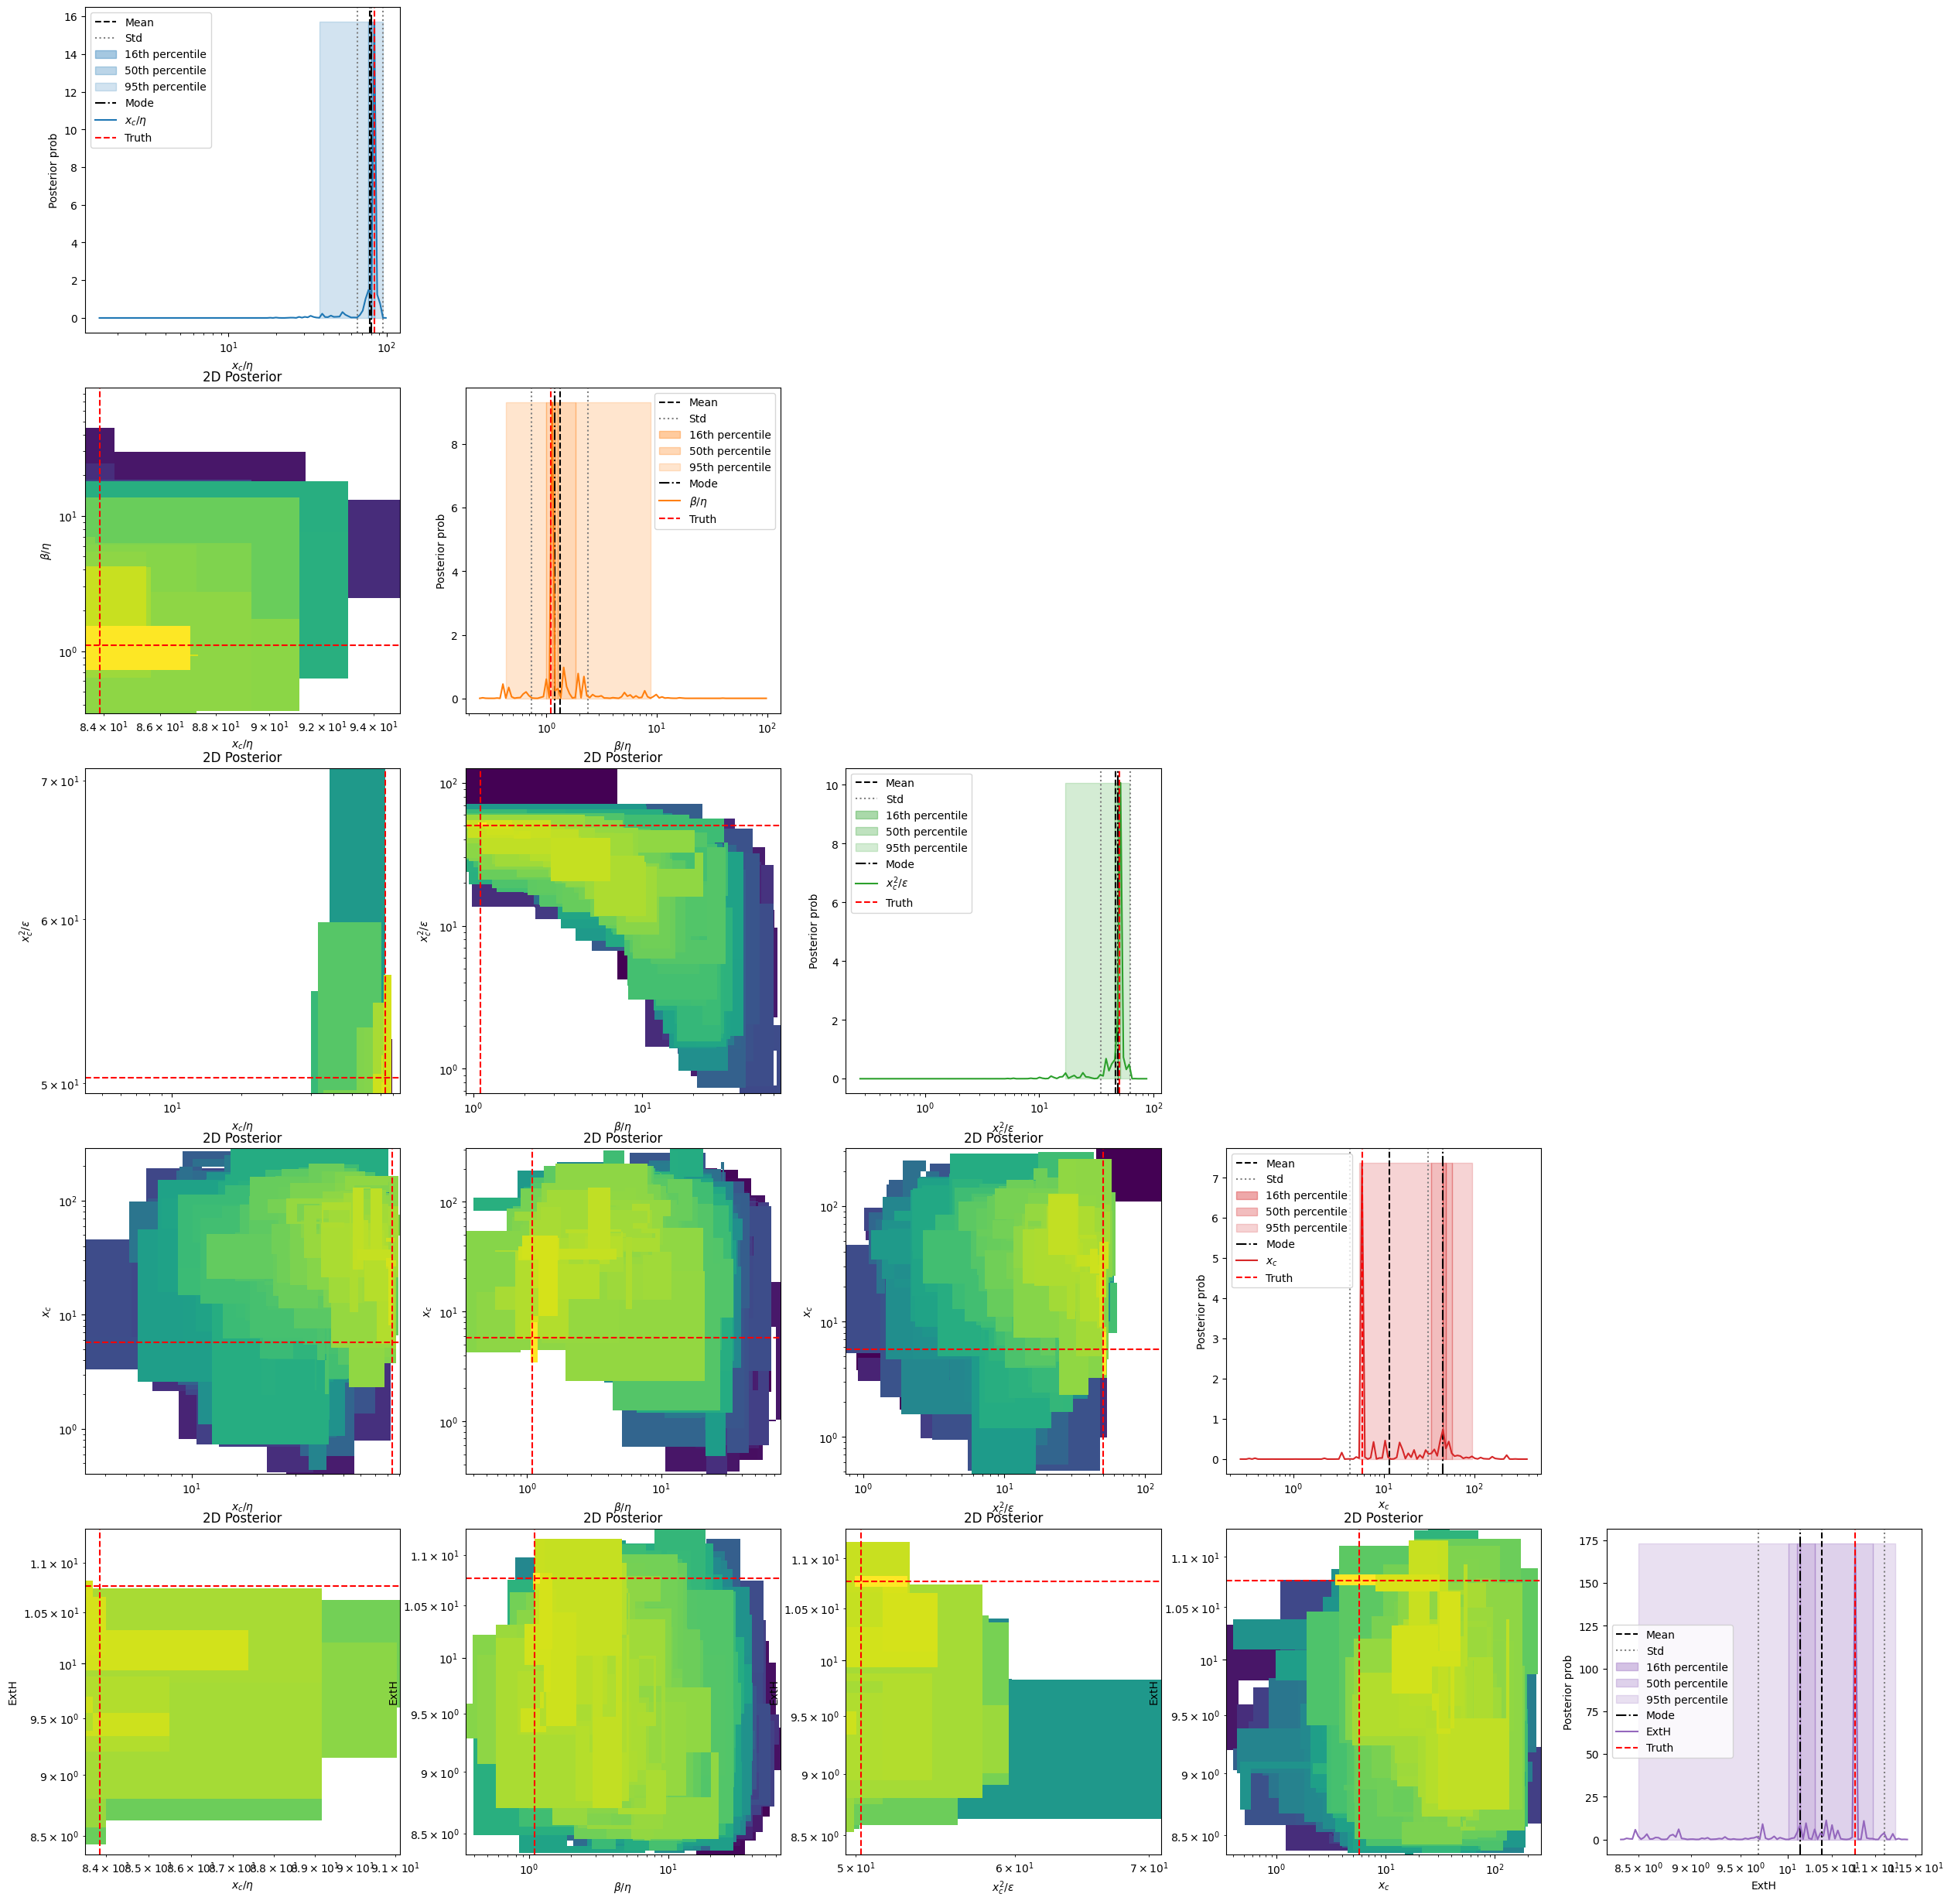

In [24]:
post.corner_plot(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"], truths=sorted_samples_trans[-1],scale='log',show_ln_prob=False,norm='log',plot_type="pcolormesh")

In [25]:
path_days = f"{results_path.split('.csv')[0]}_days.csv" if results_path is not None else None
df=post.create_posterior_df(filepath=results_path, ds = [best_sim,ds], ds_labels=['best fit','data'])
df_days=post.create_posterior_df(filepath=path_days, ds = [best_sim,ds], ds_labels=['best fit','data'],rescale=365)

Averaging log-probabilities: 100%|██████████| 6396/6396 [00:00<00:00, 282482.19it/s]


Rescaling the samples TIME by 365


Averaging log-probabilities: 100%|██████████| 6397/6397 [00:00<00:00, 301109.48it/s]


In [26]:
df

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
xc/eta,78.803,"[16.447, 13.607]",80.248,"[80.248, 80.248]","[76.94, 83.699]","[37.614, 94.965]",83.865
beta/eta,1.33,"[1.067, 0.592]",1.199,"[1.129, 1.273]","[1.0, 1.828]","[0.43, 8.768]",1.1
xc^2/epsilon,46.436,"[16.065, 11.936]",48.568,"[48.568, 48.568]","[45.818, 51.484]","[17.005, 61.325]",50.287
xc,11.431,"[19.277, 7.176]",45.271,"[45.271, 48.736]","[33.703, 56.484]","[5.331, 94.661]",5.755
ExtH,10.379,"[0.737, 0.688]",10.14,"[10.108, 10.301]","[10.013, 10.972]","[8.498, 11.253]",10.763
eta,0.141,"[0.275, 0.0931]",0.633,"[0.52, 0.633]","[0.318, 0.77]","[0.0726, 3.371]",0.0686
beta,0.187,"[0.602, 0.143]",1.26,"[0.975, 1.433]","[0.271, 1.629]","[0.0581, 24.051]",0.0755
epsilon,2.812,"[20.115, 2.467]",40.039,"[33.455, 40.039]","[19.516, 68.635]","[0.643, 495.188]",0.659
sqrt(xc/eta),8.876,"[0.884, 0.804]",8.958,"[8.958, 8.958]","[8.772, 9.149]","[6.133, 9.745]",9.158
s= eta^0.5*xc^1.5/epsilon,5.173,"[1.159, 0.947]",5.512,"[5.512, 5.512]","[5.092, 5.734]","[2.597, 6.207]",5.491


In [27]:
#get the theta of the modes of the posterior (from the df) location of indexes eta, beta, epsilon, xc and columen 'mode'
theta_mode =  df.loc[['eta','beta','epsilon','xc'],'mode'].values
print(f"theta_mode: {theta_mode}")
theta_mode_trans = df.loc[['xc/eta','beta/eta','xc^2/epsilon','xc'],'mode'].values
print(f"theta_mode_trans: {theta_mode_trans}")
sim_mode = srh.getSrHetro(theta_mode, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard,parallel=True,hetro=hetro)
sim_mode_trans = srh.getSrHetro(srmc.inv_transform(theta_mode_trans), nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard,parallel=True,hetro=hetro)


theta_mode: [0.633 1.26 40.039 45.271]
theta_mode_trans: [80.248 1.199 48.568 45.271]


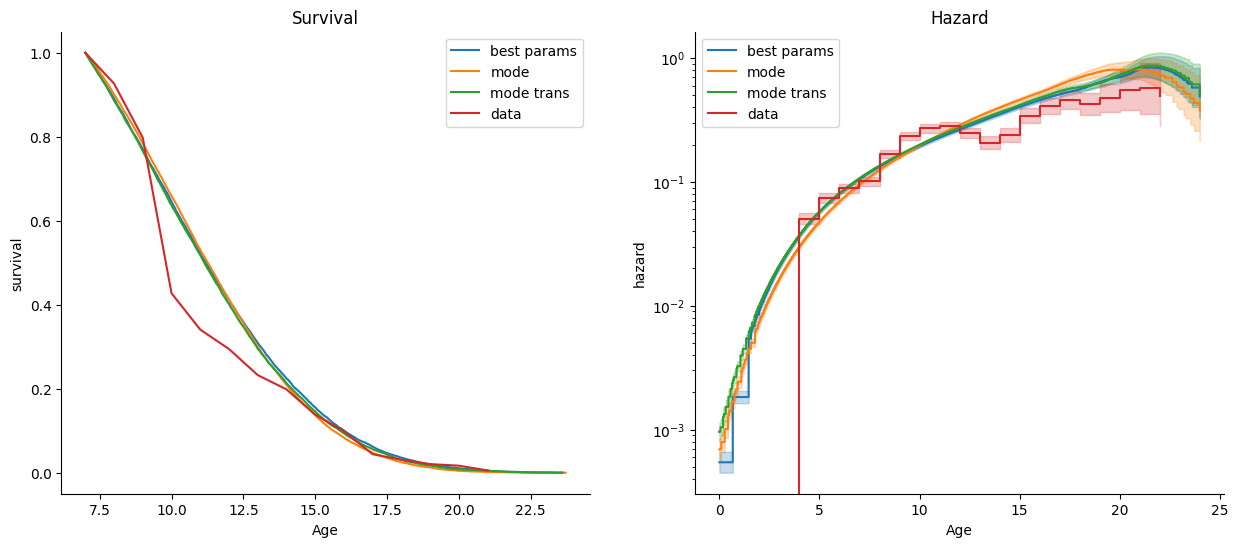

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0],time_range=time_range, label='best params', title='Survival', xlabel='time [years]', ylabel='survival')
sim_mode.plotSurvival(ax=ax0,time_range=time_range, label='mode')
sim_mode_trans.plotSurvival(ax=ax0,time_range=time_range, label='mode trans')
ds.plotSurvival(ax=ax0,time_range=time_range, label='data')
ax0.legend()

# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time [years]', ylabel='hazard', label='best params')
sim_mode.plotHazard(ax=ax1, label='mode')
sim_mode_trans.plotHazard(ax=ax1, label='mode trans')
ds.plotHazard(ax=ax1, label='data')
ax1.set_yscale('log')

Averaging log-probabilities: 100%|██████████| 4832/4832 [00:00<00:00, 251369.00it/s]


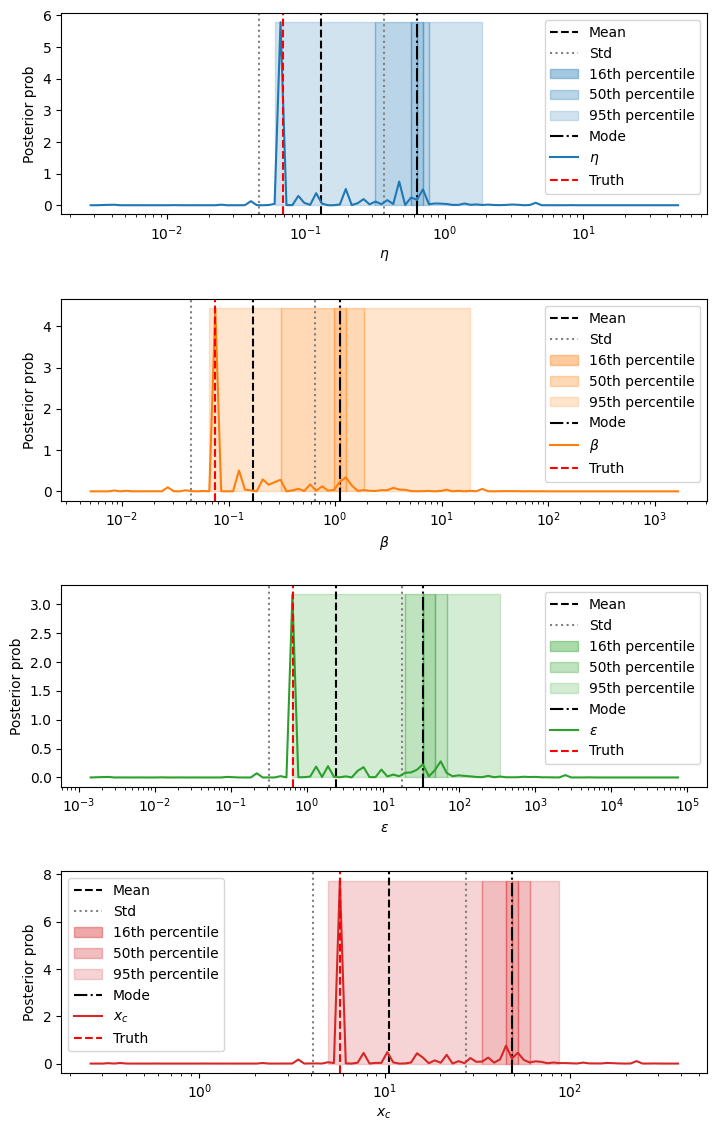

In [29]:
post_regular_params = su.Posterior(samples, lnprobs, 100, log=True)
post_regular_params.plot_1d_posteriors(labels=["$\\eta$","$\\beta$","$\\epsilon$","$x_c$"], truths=sorted_samples[-1],scale='log')